In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import multiprocessing as mp
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})
plt.rcParams.update({'legend.fontsize': 12})


In [23]:
class Option:
    def __init__(self,X0=100,r=0.05,sig=0.2,K=100,T=1,M=2):
        self.X0=X0
        self.r=r
        self.sig=sig
        self.K=K
        self.T=T
        self.M=M
    
    #Virtual functions to be overridden by specific sub-classes
    def payoff(N_loop,l): #Depends on option type
        raise NotImplementedError()
    def path(N_loop,l): #Depends on underlying SDE
        raise NotImplementedError()
    
    #~~~Common functions to all sub-classes~~~#
    def summer(N_loop,l):
        Pf,Pc=payoff(N_loop,l)
        sumPf=np.sum(Pf)
        sumPf2=np.sum(Pf**2)
        if l==0:
            suml=np.array([sumPf,sumPf2,sumPf,sumPf2,0,0,0])
        else:
            dP_l=Pf-Pc #Payoff difference
            sumPc=np.sum(Pc)
            sumPc2=np.sum(Pc**2)
            fg=np.sum(Pc*Pf)
            suml=np.array([np.sum(dP_l),np.sum(dP_l**2),sumPf,sumPf2,sumPc,sumPc2,fg])
        return suml
    
    def looper(Nl,l,Npl=10**4):
        num_rem=Nl #Initialise remaining samples for while loop
        suml=np.zeros(7)
        while (num_rem>0): #<---Parallelise this while loop
            N_loop=min(Npl,num_rem) #Break up Nl into manageable chunks of size Npl, until last iteration
            num_rem-=N_loop #On final iteration N_loop=num_rem, so num_rem will be=0 and 
            suml+=summer(N_loop,l)
        return suml

class Asian_GBM(Option):
    def path(N_loop,l):
        M=self.M
        r=self.r
        sig=self.sig
        T=self.T
        K=self.K
        X0=self.X0
        Nsteps=M**l
        dt=T/Nsteps        
        sqrt_dt=np.sqrt(dt)
        #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
        Xf=X0*np.ones(N_loop)
        Xc=X0*np.ones(N_loop)
        Af=0.5*dt*Xf
        Ac=0.5*M*dt*Xc
        dWc=np.zeros(N_loop)
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
            Af+=Xf*dt
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                Ac+=Xc*M*dt
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0

        Af-=0.5*Xf*dt
        Ac-=0.5*Xc*M*dt
        
        return Af,Ac
    
    def payoff(N_loop,l):
        r=self.r
        T=self.T
        K=self.K
        Af,Ac=path(N_loop,l)
        #Calculate payoffs etc.
        Pf=np.exp(-r*T)*np.maximum(0,Af-K) #Payoff at fine level
        if l==0:
            return Pf,Ac
        else:
            Pc=np.exp(-r*T)*np.maximum(0,Ac-K)
            return Pf,Pc
        

class Lookback_GBM(Option):
    def __init__(self,X0=100,r=0.05,sig=0.2,T=1,M=2):
        super().__init__(X0=100,r=0.05,sig=0.2,T=1,M=2)
        self.K=None
        self.beta=0.5826  #special factor for offset correction
    
    def path(N_loop,l):
        M=self.M
        r=self.r
        sig=self.sig
        T=self.T
        X0=self.X0
        Nsteps=M**l
        dt=T/Nsteps
        sqrt_dt=np.sqrt(dt)
        #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
        Xf=X0*np.ones(N_loop)
        Xc=X0*np.ones(N_loop)
        Mf=X0*np.ones(N_loop)
        Mc=X0*np.ones(N_loop)
        dWc=np.zeros(N_loop)
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
            Mf=np.minimum(Xf,Mf)
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                Mc=np.minimum(Xc,Mc)
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0
        return Xf - Mf*(1-beta*sig*sqrt_dt),Xc - Mc*(1-beta*sig*np.sqrt(M*dt))
    
    def payoff(N_loop,l):
        r=self.r
        T=self.T
        Pf,Pc=path(N_loop,l)
        #Calculate payoffs etc.
        Pf=np.exp(-r*T)*Pf #Payoff at fine level
        if l==0:
            return Pf,Pc #Just ignore Pc
        else:
            Pc=np.exp(-r*T)*Pc #Payoff at coarse level
            return Pf,Pc
        
class Euro_GBM(Option):
    def path(N_loop,l):
        M=self.M
        r=self.r
        sig=self.sig
        T=self.T
        X0=self.X0
        Nsteps=M**l
        dt=T/Nsteps
        sqrt_dt=np.sqrt(dt)
        #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
        Xf=X0*np.ones(N_loop)
        Xc=X0*np.ones(N_loop)
        dWc=np.zeros(N_loop)
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
        if j%M==0: #if j is integer multiple of M...
            Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
            dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0
        return Xf,Xc
    
    def payoff(N_loop,l):
        r=self.r
        T=self.T
        K=self.K
        Xf,Xc=path(N_loop,l)
        #Calculate payoffs etc.
        Pf=np.exp(-r*T)*np.maximum(0,Xf-K)
        if l==0:
            return Pf,Xc #Just ignore Pc=Xc
        else:
            Pc=np.exp(-r*T)*np.maximum(0,Xc-K) #Payoff at coarse level
            return Pf,Pc   
        
class Digital_GBM(Euro_GBM):
    def payoff(N_loop,l):
        r=self.r
        T=self.T
        K=self.K
        Xf,Xc=path(N_loop,l)
        #Calculate payoffs etc.
        Pf=np.exp(-r*T)*K*(Xf>K).astype(np.int_)
        if l==0:
            return Pf,Xc #Just ignore Pc=Xc
        else:
            Pc=np.exp(-r*T)*K*(Xc>K).astype(np.int_) #Payoff at coarse level
            return Pf,Pc   
       

In [6]:
def _parallel_mc(iter=1000):
    pool = mp.Pool(4)

    future_res = [pool.apply_async(sample) for _ in range(iter)]
    res = [f.get() for f in future_res]

    return res

In [14]:
def mlmc(option,eps,N0=10**3):
    '''
    Runs MLMC method for given option (e.g. European) which returns an array of sums at each level: 
    suml=[d_Pl,d_Pl**2,Pl,Pl**2].
    __Inputs__
    option = option instance (with SDE params and coarseness factor M)
    eps = desired accuracy
    N0 = default number of samples to use when initialising new level
    M=coarseness factor
    
    __Outputs__
    sums = array of sums of payoff differences between coarse and fine paths at each level and
           sum of payoffs at fine level, each column is a level
    N = final number of samples at each level
    '''
    L=2
    M=option.M
    
    V=np.zeros(L+1) #Initialise variance vector of each levels' variance
    N=N0*np.ones(L+1) #Initialise num. samples vector of each levels' num. samples
    dN=N0*np.ones(L+1) #Initialise additional samples for this iteration vector for each level
    sums=np.zeros((7,L+1)) #Initialise sums array, each column is a level
    sqrt_h=np.sqrt(M**(np.arange(L+1)))

    while (np.sum(dN)>0): #Loop until no additional samples asked for
        for l in range(L+1): 
            num=dN[l]
            if num>0: #If asked for additional samples...
                sums[:,l]+=option.looper(int(num),l) #Call function which gives sums

        
        N+=dN #Increment samples taken counter for each level        
        V=np.maximum((sums[1,:]/N)-(sums[0,:]/N)**2,0) #Calculate variance based on updated samples
        sqrt_V=np.sqrt(V)
        Nl_new=np.ceil((2/eps**2)*np.sum(sqrt_V*sqrt_h)*sqrt_V/sqrt_h) #Estimate optimal number of samples at each level
        dN=np.maximum(0,Nl_new-N) #Number of additional samples
        if sum(dN > 0.01*N) == 0:
            if abs(sums[0,-1])/N[-1]>(M-1)*eps*np.sqrt(0.5):
                L+=1
                #Add extra entries for the new level and estimate sums with N0 samples 
                V=np.concatenate((V,np.zeros(1)), axis=0)
                N=np.concatenate((N,N0*np.ones(1)),axis=0)
                dN=np.concatenate((dN,N0*np.ones(1)),axis=0)
                sqrt_h=np.concatenate((sqrt_h,[np.sqrt(M**L)]),axis=0)
                sums=np.concatenate((sums,np.zeros((7,1))),axis=1)
                sums[:,L]+=option.looper(N0,L)
    
    return sums,N


In [10]:
def mlmc_variance(mlmc_fn,eps,M=2,T=1,N0=10**3):
    sums,N=mlmc(European,eps,N0,M,T)
    L=len(N)-1
    means_dp=sums[0,:]/N
    means_p=sums[2,:]/N

    V_dp=(sums[1,:]/N)-means_dp**2
    V_p=(sums[3,:]/N)-means_p**2

    cost_mlmc=(N[0]+sum(N[1:]*(M**np.arange(L)+M**np.arange(1,L+1))))*eps**2
    cost_mc=2*sum(V_p*M**np.arange(L+1))
    
    fig,ax=plt.subplots(1,2,figsize=(15,8))
    fig.suptitle(f'European Call with GBM, $\epsilon=${eps}\nM={M}')
    fig.tight_layout(pad=6.0)
    ax[0].plot(range(1,L+1),np.log(V_dp[1:])/np.log(M),'k',range(L+1),np.log(V_p)/np.log(M),'b')
    ax[0].set_xlabel('$l$')
    ax[0].set_ylabel(f'log$_{M}$var')
    ax[0].legend(['$P_{l}-P_{l-1}$','$P_{l}$'])
    ax[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    ax[1].plot(range(1,L+1),np.log(means_dp[1:])/np.log(M),'k',range(L+1),np.log(means_p)/np.log(M),'b')
    ax[1].set_xlabel('$l$')
    ax[1].set_ylabel(f'log$_{M}$mean')
    ax[1].legend(['$P_{l}-P_{l-1}$','$P_{l}$'])
    ax[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.savefig('EuroCallGBM_var')

def mlmc_complexity(mlmc_fn,eps,M=2,T=1,N0=10**3):
    cost_mlmc=[]
    cost_mc=[]
    fig,ax=plt.subplots(1,2,figsize=(15,8))
    fig.suptitle(f'European Call with GBM,\nS(0)=K={X0}')
    for e in eps:
        sums,N=mlmc(mlmc_fn,e,N0,M,T)
        L=len(N)-1
        means_p=sums[2,:]/N
        V_p=(sums[3,:]/N)-means_p**2

        cost_mlmc+=[(N[0]+(1+1/M)*np.sum(N[1:]*(M**np.arange(1,L+1))))*e**2]
        cost_mc+=[2*sum(V_p*M**np.arange(L+1))]
        ax[0].semilogy(range(L+1),N,label=f'{e}')
    
    ax[0].set_xlabel('$l$')
    ax[0].set_ylabel('$N_l$')
    ax[0].legend(title=r'$\epsilon$')
    xa=ax[0].xaxis
    xa.set_major_locator(ticker.MaxNLocator(integer=True))

    ax[1].loglog(eps,cost_mlmc,'k',label=label)
    ax[1].set_xlabel(r'$\epsilon$')
    ax[1].set_ylabel(r'$\epsilon^{2}$cost')
    ax[1].legend(['mlmc','mc'])
    plt.savefig('EuroCallGBM_cost')

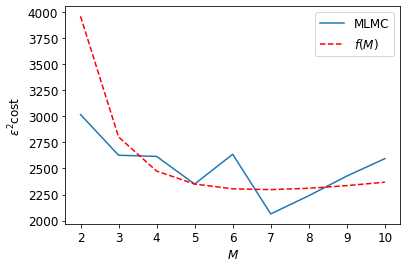

In [18]:
cost_mlmc=[]
cost_mc=[]
for m in [2,3,4,5,6,7,8,9,10]:
    e=0.0005
    sums,N=mlmc(European,e,M=m)
    L=len(N)-1
    means_p=sums[2,:]/N
    V_p=(sums[3,:]/N)-means_p**2

    cost_mlmc+=[(N[0]+(1+1/m)*np.sum(N[1:]*(m**np.arange(1,L+1))))*e**2]
    cost_mc+=[2*sum(V_p*m**np.arange(L+1))]

M=np.array([2,3,4,5,6,7,8,9,10])
plt.plot(M,cost_mlmc,label='MLMC')
sc=cost_mlmc[3]/((M[3]-1/M[3])/(np.log(M[3]))**2)
plt.plot(M,sc*(M-1/M)/(np.log(M))**2,'r--',label='$f(M)$')
plt.legend()
plt.ylabel('$\epsilon^{2}$cost')
plt.xlabel('$M$');
plt.savefig('Comparison_Cost_fofM')

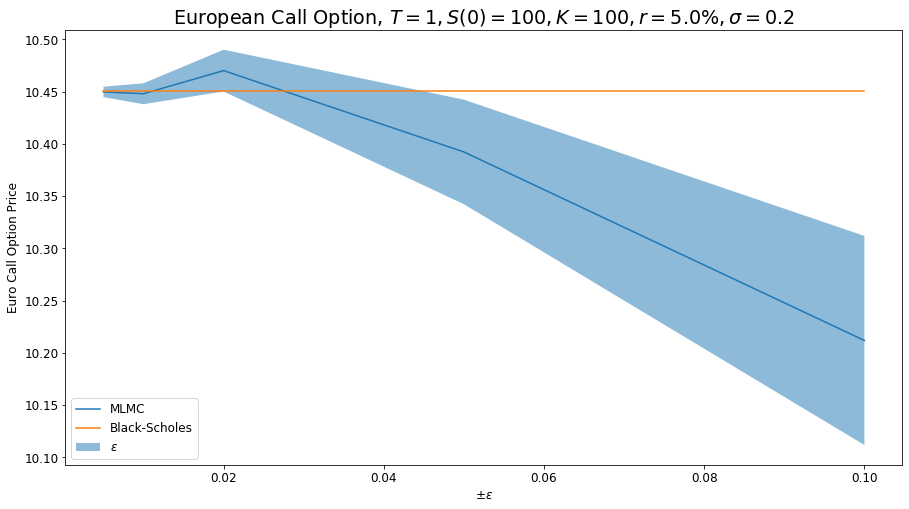

In [13]:
plt.figure(figsize=(15,8))
p=[]
eps=np.array([0.005,0.01,0.02,0.05,0.1])
for e in eps:
        sums,N=mlmc(European,e,M=4)
        p+=[np.sum(sums[0,:]/N)]
plt.plot(eps,p,label='MLMC')
plt.fill_between(eps, p+eps, p-eps, alpha=.5, label='$\pm\epsilon$')
plt.plot(eps,BS*np.ones(len(eps)),label='Black-Scholes')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Euro Call Option Price')
plt.title(f'European Call Option, $T={T}, S(0)={X0}, K={K}, r={r*100}\%, \sigma={sig}$');

C:\Users\s1505582\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


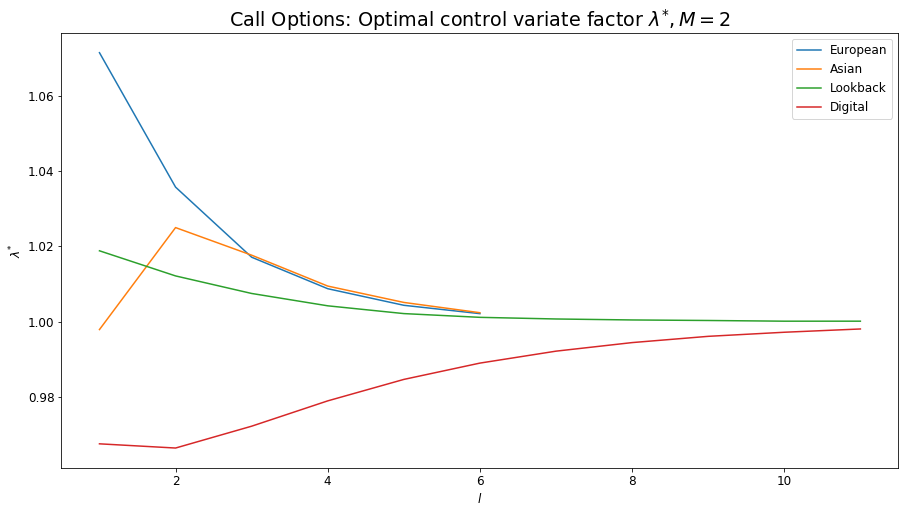

In [19]:
plt.figure(figsize=(15,8))
for label,func in {'European':European,'Asian':Asian,'Lookback':Lookback,'Digital':Digital}.items():
    p=[]
    sums,N=mlmc(func,0.005,M=2)
    Vg=sums[5,:]/N-(sums[4,:]/N)**2
    lam=((sums[6,:]/N)-(sums[2,:]/N)*(sums[4,:]/N))/Vg
    plt.plot(range(len(N)),lam,label=label)

plt.xlabel('$l$')
plt.ylabel('$\lambda^{*}$')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.title('Call Options: Optimal control variate factor $\lambda^{*}, M=2$');
plt.legend()
plt.savefig('lambdaCallOptions')

In [33]:
class Euro_Merton(Option):
    '''
    S_t+h=Y*S_t => dS=S_t+h-S_t=(Y-1)*S_t
    Q=ln(Y)~N(a,b) for example
    dS=(r-c*lam*Jbar)Sdt+sig*S*dW+c*S*dJ
    dJ=exp(Q)-1 #Size of jump
    Jbar=E[exp(Q)-1] #Expected jump size
    '''
    def __init__(self,c=1,lam=1,ran=np.random.standard_normal,J_bar=None,**kwargs):
        super().__init__(**kwargs)
        self.lam=lam
        self.c=c
        if J_bar==None:
            if Q_ran!=np.random.standard_normal:
                raise ValueError("If specifying random distribution for Q, specify Jbar=E[exp(Q)-1].")
            else:
                self.J_bar=np.exp(0.5)-1
        else:
            self.J_bar=J_bar
        self.ran=ran
        
    def BS(x):
        D1 =(np.log(x/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
        D2 = D1 - sig*np.sqrt(T)
        c=x*norm.cdf(D1)-K*np.exp(-r*T)*norm.cdf(D2)
        return c
    
    def path(N_loop,l):
        ##Jump diffusion goes here

In [16]:
##Antithetic stuff
dWc=np.zeros(N_loop)
    for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
        if j%2==1:# if odd
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWa=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
            Xa+=r*Xa*dt + sig*Xa*dWa
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                Ac+=Xc*M*dt
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0
        else:
            dWc=dWc+dWa #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWa
            Xa+=r*Xa*dt + sig*Xa*dWf
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                Ac+=Xc*M*dt
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0

In [ ]:
##Jump Diffusion Model Attempt
N_loop=1
dWc=np.zeros(N_loop)
tau=0
t_=0
i=0
Xf=X0*np.ones(N_loop)
tau+=np.random.exponential(scale=1/lam,N_loop)
for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
        tn=j*T/Nsteps
        while tau<tn:
            dt=tau-t_
            dWf=np.random.randn(N_loop)*np.sqrt(dt)
            dJ=np.exp(ran(N_loop))-1
            Xf+=(r-c*lam*self.Jbar)*Xf*dt + sig*Xf*dWf+c*Xf*dJ
            t_=tau
            tau+=np.random.exponential(scale=1/lam,N_loop)
            i+=1
        dt=tn-t_
        dWf=np.random.randn(N_loop)*np.sqrt(dt)
        Xf+=(r-c*lam*self.Jbar)*Xf*dt + sig*Xf*dWf
        t_=tn